In [1]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from fastai.vision.all import *
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import csv

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock, imagenet_stats
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

from keras.preprocessing.image import ImageDataGenerator

from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlopen

In [3]:
#https://walkwithfastai.com/Multi_Label used as an example
df = pd.read_csv('train.csv')
not_in_data = []
for i, row in df.iterrows():
  if not os.path.isfile(f'images/{row.image_id}'):
    not_in_data.append(row.image_id)

df = df[~df.image_id.isin(not_in_data)]

In [4]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, pref='images/'),
                  splitter=RandomSplitter(seed=1111),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms=Resize(600),
                  batch_tfms = batch_tfms)

In [5]:
df

,image_id,labels
0,img256.jpg,l16 l18 l23 l25 l73
1,img98.jpg,l0 l24 l26 l39
2,img147.jpg,l14 l3
3,img254.jpg,l2 l25 l29
4,img160.jpg,l0 l32 l38 l40 l6
...,...,...
200,img105.jpg,l51
201,img198.jpg,l0 l10 l11 l65 l7
202,img82.jpg,l2
203,img124.jpg,l0 l1 l19 l22 l34 l6


In [6]:
dls = db.dataloaders(df, bs=32)

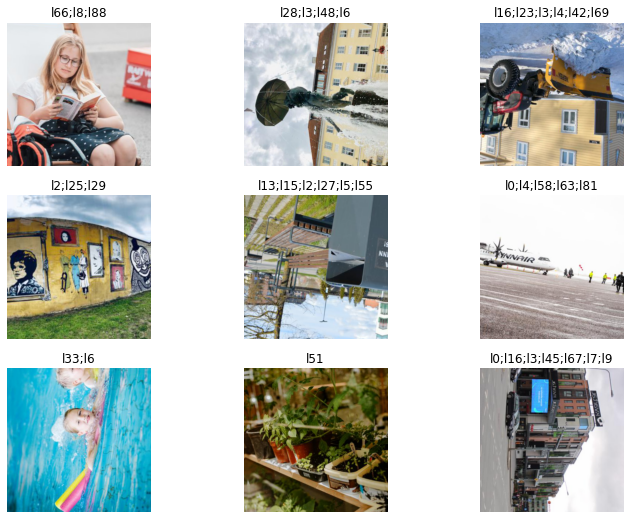

In [7]:
dls.show_batch(max_n=9, figsize=(12,9))

In [8]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [9]:
#Custom loss function from
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.6, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [10]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.001737800776027143)

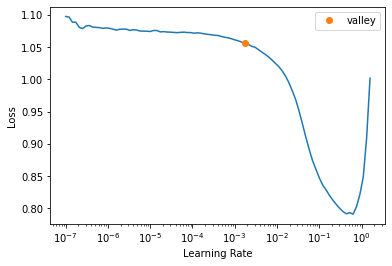

In [11]:
learn.lr_find()

In [12]:
lr = 0.003

In [13]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.061354,1.037961,0.489674,00:06
1,1.052352,0.870762,0.488859,00:06
2,1.040511,0.807594,0.505435,00:07
3,1.020541,0.769839,0.537772,00:06
4,0.994849,0.736981,0.568478,00:06
5,0.966147,0.696086,0.598641,00:06
6,0.933126,0.642002,0.645109,00:06
7,0.899061,0.574788,0.702989,00:06
8,0.858460,0.511182,0.763587,00:06
9,0.811904,0.425386,0.842935,00:06


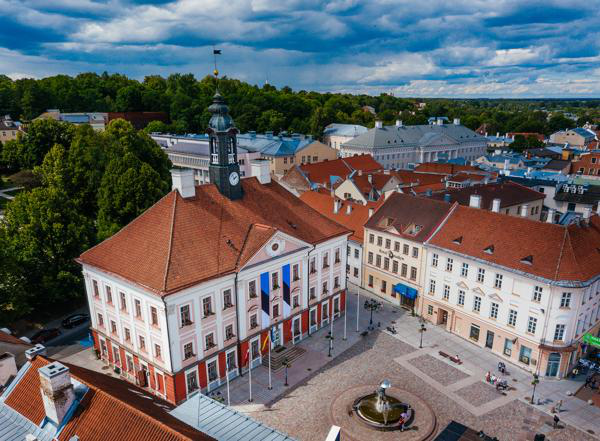

In [14]:
img = load_image('images/img102.jpg')
img

In [15]:
for i in learn.predict('images/img102.jpg')[0]:
  print(i) 

l1
l41


In [16]:
df_test = pd.read_csv('test.csv')
df_test

,image_id
0,img102.jpg
1,img103.jpg
2,img11.jpg
3,img113.jpg
4,img114.jpg
...,...
83,img81.jpg
84,img84.jpg
85,img90.jpg
86,img93.jpg


In [17]:
not_in_data = []
for i, row in df_test.iterrows():
  if not os.path.isfile(f'images/{row.image_id}'):
    not_in_data.append(row.image_id)

df_test = df_test[~df_test.image_id.isin(not_in_data)]

In [18]:
not_in_data

[]

In [19]:
learn.dls.vocab

['l0', 'l1', 'l10', 'l11', 'l12', 'l13', 'l14', 'l15', 'l16', 'l17', 'l18', 'l19', 'l2', 'l20', 'l21', 'l22', 'l23', 'l24', 'l25', 'l26', 'l27', 'l28', 'l29', 'l3', 'l30', 'l31', 'l32', 'l33', 'l34', 'l35', 'l36', 'l37', 'l38', 'l39', 'l4', 'l40', 'l41', 'l42', 'l43', 'l44', 'l45', 'l46', 'l47', 'l48', 'l49', 'l5', 'l50', 'l51', 'l52', 'l53', 'l54', 'l55', 'l56', 'l57', 'l58', 'l59', 'l6', 'l60', 'l61', 'l62', 'l63', 'l64', 'l65', 'l66', 'l67', 'l68', 'l69', 'l7', 'l70', 'l71', 'l72', 'l73', 'l74', 'l75', 'l76', 'l77', 'l78', 'l79', 'l8', 'l80', 'l81', 'l82', 'l83', 'l84', 'l85', 'l86', 'l87', 'l88', 'l89', 'l9', 'l90', 'l91']

In [20]:
test_labels = []
classes = learn.dls.vocab
for i in df_test.image_id:
  #preds = learn.get_preds()
  pred_class, pred_idxs, outputs = learn.predict(f'images/{i}')
  if len(pred_class) < 1:
      pred_class = [classes[np.argmax(outputs)]]
  elif len(pred_class) > 7:
    pred_class = [classes[i] for i in outputs.topk(7)[1]]
  test_labels.append(" ".join(pred_class))

In [21]:
len(test_labels)

88

In [22]:
df_test.insert(1, "labels", test_labels, True)
df_test

,image_id,labels
0,img102.jpg,l1 l41
1,img103.jpg,l1 l10
2,img11.jpg,l4
3,img113.jpg,l10
4,img114.jpg,l13
...,...,...
83,img81.jpg,l2
84,img84.jpg,l68
85,img90.jpg,l0
86,img93.jpg,l36 l48 l77


In [23]:
df_test.to_csv('out.csv', index=False)

In [31]:
from google.colab import files

files.upload();

Saving kaggle.json to kaggle.json


In [32]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [24]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f out.csv -m "Predictions"

100% 1.40k/1.40k [00:02<00:00, 493B/s]
Successfully submitted to Object recognition for The Image Bank of Tartu (2)